# Predicting Penguin species with sklearn

This notebook is an end to end sample for -
1. Training a Scikit-Learn Random Forest Classifier model
2. Registering the model in Vertex AI model registry
3. Operationalizing the model for online predictions in Vertex AI endpoints
4. Online inferencing from Python

It includes:
1. Curating the training data source in BigQuery
2. Profiling the data
3. Exploratory data analysis
4. Feature engineering
5. Model training
6. Model registration into Vertex AI Model Registry
7. Deployment of model to Vertex AI Endpoint
8. Online inferencing

# Module 01: Profiling and Exploratory Data Analysis

In this module we will understand the dataset that we will use to train a model with Ray in subsequent modules.

## M01-1. About the use case and source data






### M01-1.1 Goals

### M01-1.2. Use case

Prediction of Penguin species given a set of attributes describing a Penguin.







### M01-1.3. Machine Learning Library

| Aspect | Detail  |
| -- | :--- |
| ML  type | Supervised Learning |
| ML category | Classification |
| ML library | SkLearn |




### M01-1.4. Data

| Aspect | Detail  |
| -- | :--- |
| Data source | BigQuery Public Dataset - `bigquery-public-data.ml_datasets.penguins` |
| Rows | 344 |

In [93]:
# Variables
project_id_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = project_id_output[0]
print("Project ID: ", PROJECT_ID)

project_nbr_output = !gcloud projects describe $PROJECT_ID --format='value(projectNumber)'
PROJECT_NBR = project_nbr_output[0]
print("Project Number: ", PROJECT_NBR)

REGION="us-central1"
print("GCP region: ", REGION)

Project ID:  ray-of-sunshine
Project Number:  567162267085
GCP region:  us-central1


## M01-2. Curate the training source



### M01-2.1. Review the source data in BigQuery

In [1]:
%%bigquery

SELECT *
    FROM `bigquery-public-data.ml_datasets.penguins`
    LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie Penguin (Pygoscelis adeliae),Dream,36.6,18.4,184.0,3475.0,FEMALE
1,Adelie Penguin (Pygoscelis adeliae),Dream,39.8,19.1,184.0,4650.0,MALE


### M01-2.2. Curate the public data into your BigQuery dataset

In [3]:
%%bigquery

# Lets subset the species to a short form & persist the data as a table in our BigQuery dataset
CREATE OR REPLACE TABLE `ray_lab_ds.penguins_curated` AS
SELECT REGEXP_EXTRACT(species, r'\w+') species, island, culmen_length_mm, culmen_depth_mm, flipper_length_mm, body_mass_g, sex
    FROM `bigquery-public-data.ml_datasets.penguins`


Query is running:   0%|          |

""


## M01-3. Profile the data

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #simple data visualization
import seaborn as sns #some advanced data visualizations
import warnings

%matplotlib inline
plt.style.use('seaborn-white') #defining desired style of viz
warnings.filterwarnings('ignore') # to get rid of warnings

<ipython-input-4-8489393543ae>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white') #defining desired style of viz


In [5]:
from google.cloud import bigquery

client = bigquery.Client()
sql = """
    SELECT *
    FROM `ray_lab_ds.penguins_curated`
"""

pdf = client.query(sql).to_dataframe()

In [6]:
print('Dataset has', pdf.shape[0] , 'rows and', pdf.shape[1], 'columns')

Dataset has 344 rows and 7 columns


In [7]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [8]:
pdf.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [9]:
pdf.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

## M01-4. Exploratory Data Analysis

### M01-4.1. Univariate Analysis of categorical variables

Univariate analysis observes each characteristic or attribute in isolation. It looks at the range of values, as well as the central tendency of the values.



#### M01-4.1.1. Species

In [10]:
plt.rcParams['figure.figsize'] = (10,7)

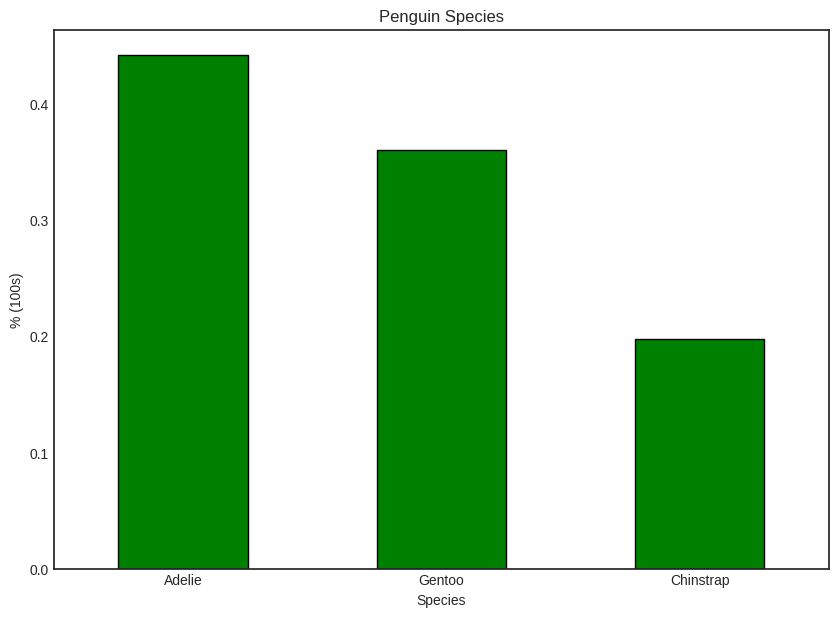

In [11]:
pdf['species'].value_counts(normalize = True).plot(kind = 'bar', color = 'green', linewidth = 1, edgecolor = 'k')
plt.title('Penguin Species')
plt.xlabel('Species')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

#### M01-4.1.2. Islands

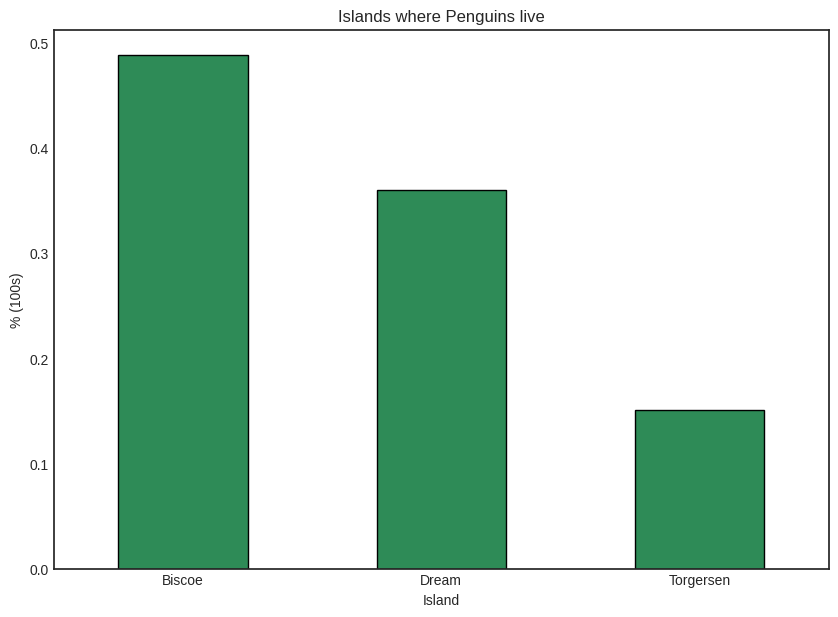

In [12]:
pdf['island'].value_counts(normalize = True).plot(kind = 'bar', color = 'seagreen', linewidth = 1, edgecolor = 'k')
plt.title('Islands where Penguins live')
plt.xlabel('Island')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

#### M01-4.1.3. Sex

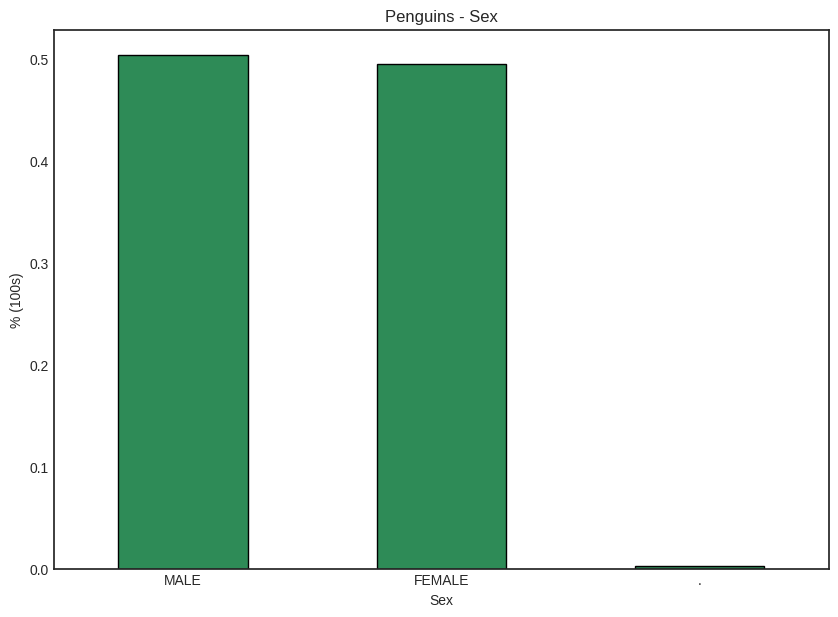

In [13]:
pdf['sex'].value_counts(normalize = True).plot(kind = 'bar', color = 'seagreen', linewidth = 1, edgecolor = 'k')
plt.title('Penguins - Sex')
plt.xlabel('Sex')
plt.ylabel('% (100s)')
plt.xticks(rotation = 360)
plt.show()

### M01-4.2. Univariable analysis of numerical variables


Probability Density Function gives the probability of a random variable x picked at a time. Empirical Cumulative Distribution Function, gives the probability of getting a value less than or equal to a random value picked at a time.


In [14]:
def display_ecd(x):
    n = len(x)
    a = np.sort(x)
    b = np.arange(1, 1 + n) / n
    plt.subplot(211)
    plt.plot(a, b, marker = '.', linestyle = 'None', c = 'seagreen')
    mean_x = np.mean(x)
    plt.axvline(mean_x, c = 'k', label = 'Mean')
    plt.title('ECDF')
    plt.legend()
    plt.show()
    plt.subplot(212)
    sns.distplot(x, color = 'r')
    plt.title('Probability Density Function')
    plt.show()

#### 4.2.1. Culmen length

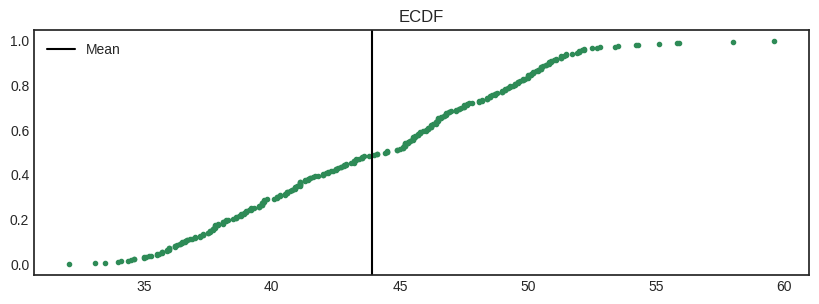

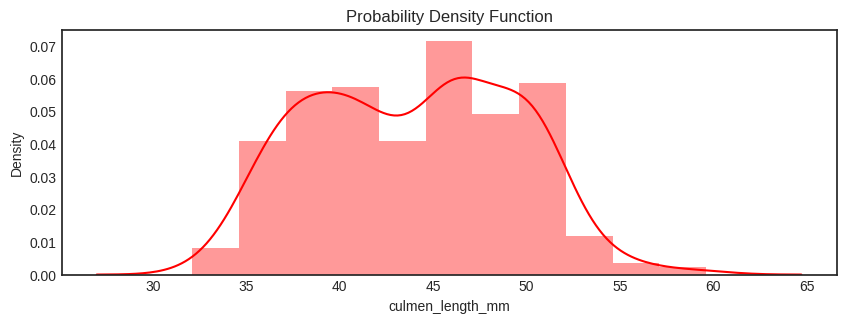

In [15]:
display_ecd(pdf['culmen_length_mm'])

#### 4.2.3. Culmen depth

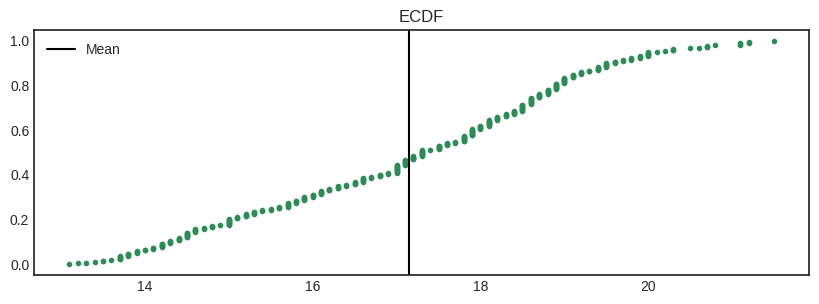

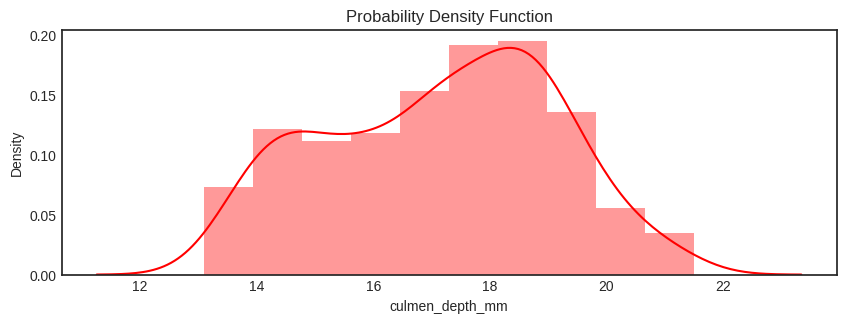

In [16]:
display_ecd(pdf['culmen_depth_mm'])

#### 4.2.4. Flipper length

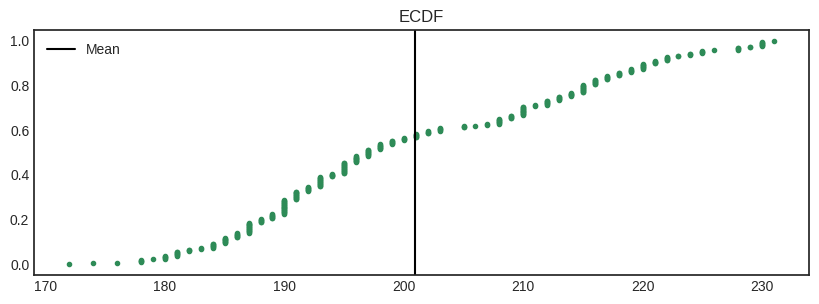

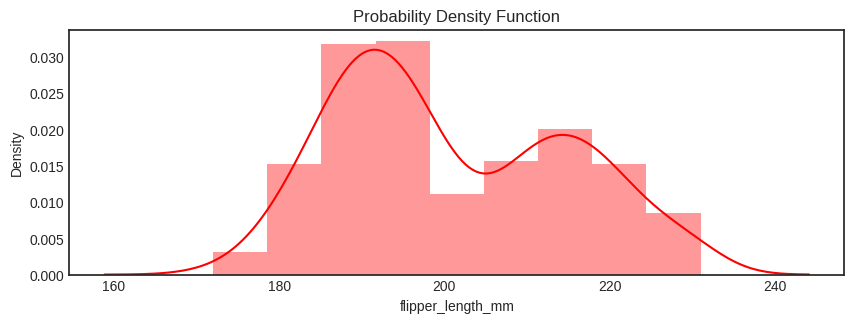

In [17]:
display_ecd(pdf['flipper_length_mm'])

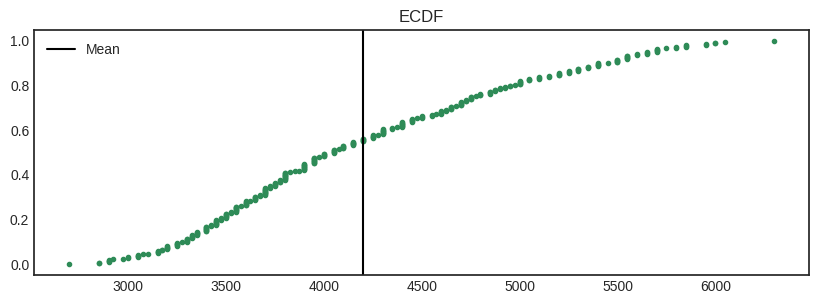

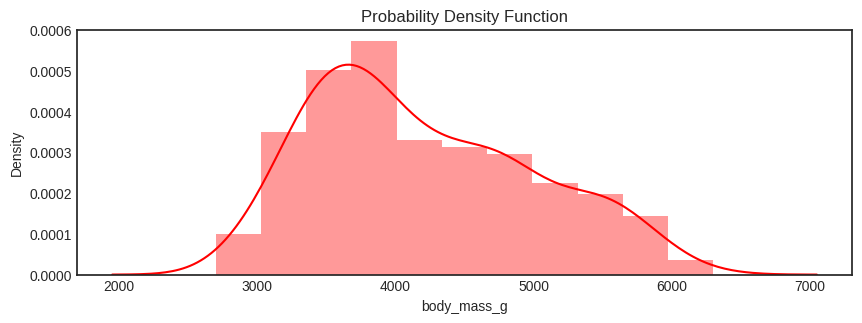

In [18]:
display_ecd(pdf['body_mass_g'])

### M01-4.3. Multivariate analysis

In [19]:
def display_boxplot(f):
    sns.boxplot(y = f, x = 'species', hue = 'sex',data = pdf)
    plt.title(f)
    plt.show()

#### M01-4.3.1. Culmen length with species and gender

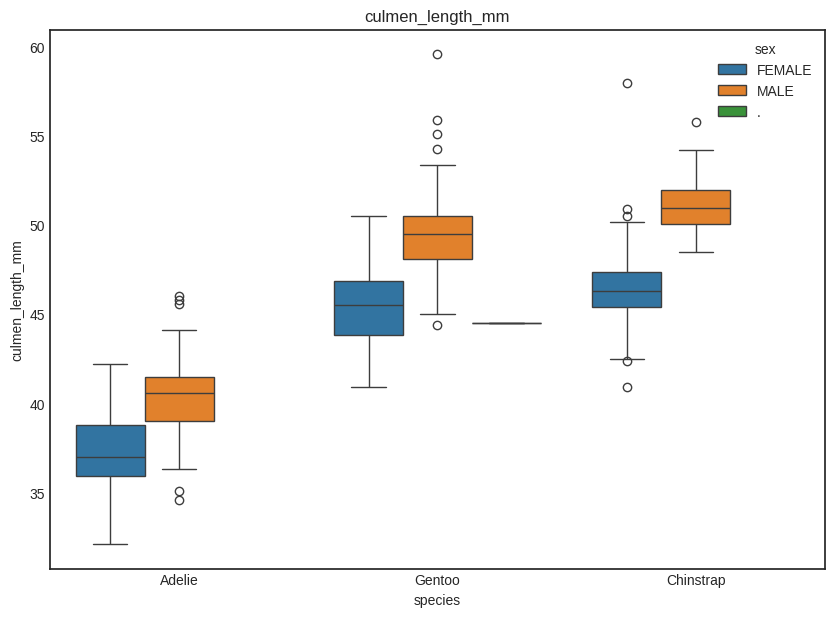

In [20]:
display_boxplot('culmen_length_mm')

#### M01-4.3.2. Culmen depth with species and gender

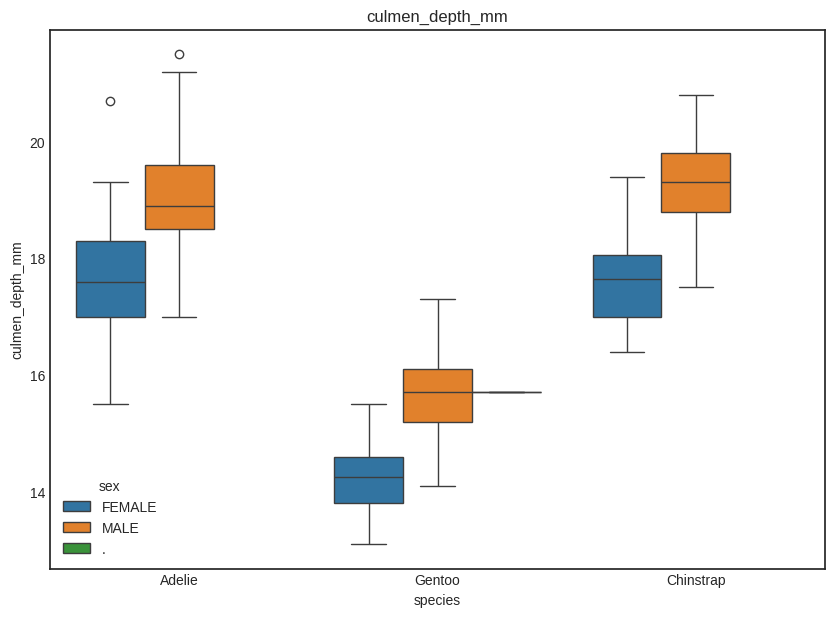

In [21]:
display_boxplot('culmen_depth_mm')


#### M01-4.3.3. Flipper length with species and gender

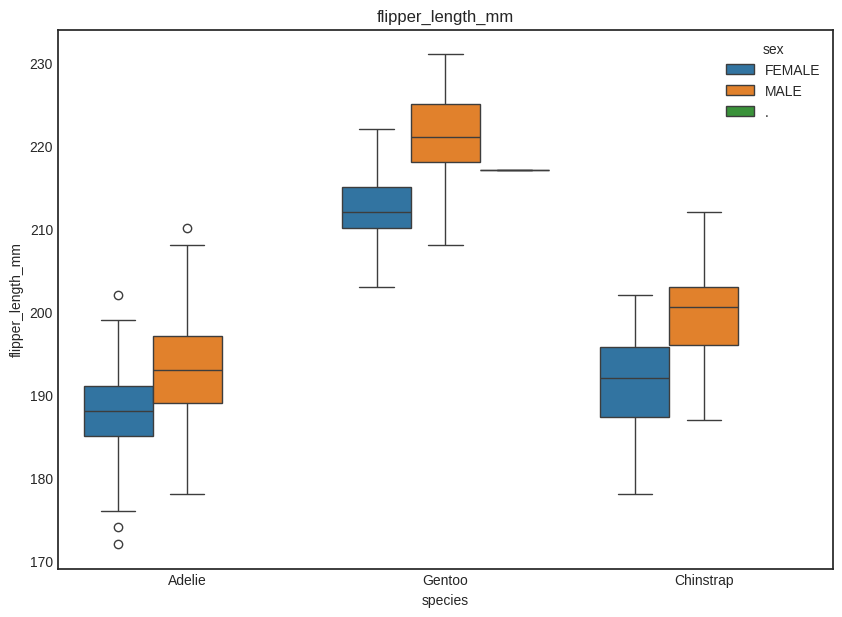

In [22]:
display_boxplot('flipper_length_mm')

#### M01-4.3.4. Body mass with species and gender

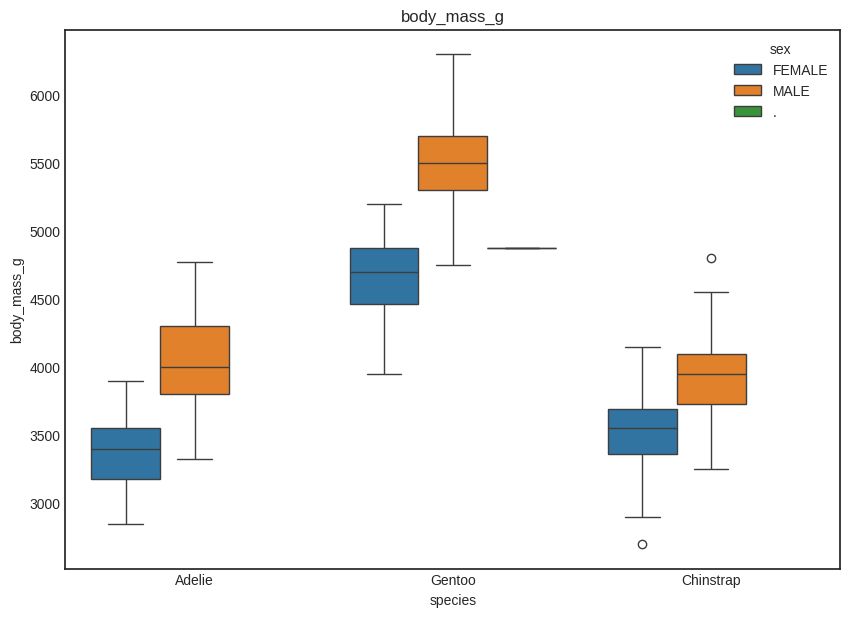

In [23]:
display_boxplot('body_mass_g')

#### **OBSERVATION:**

The male penguins have higher values of body mass, culmen & flipper lengths, culmen depth

### 4.4. **Pairplot** to visualize multivariate trends across attributes

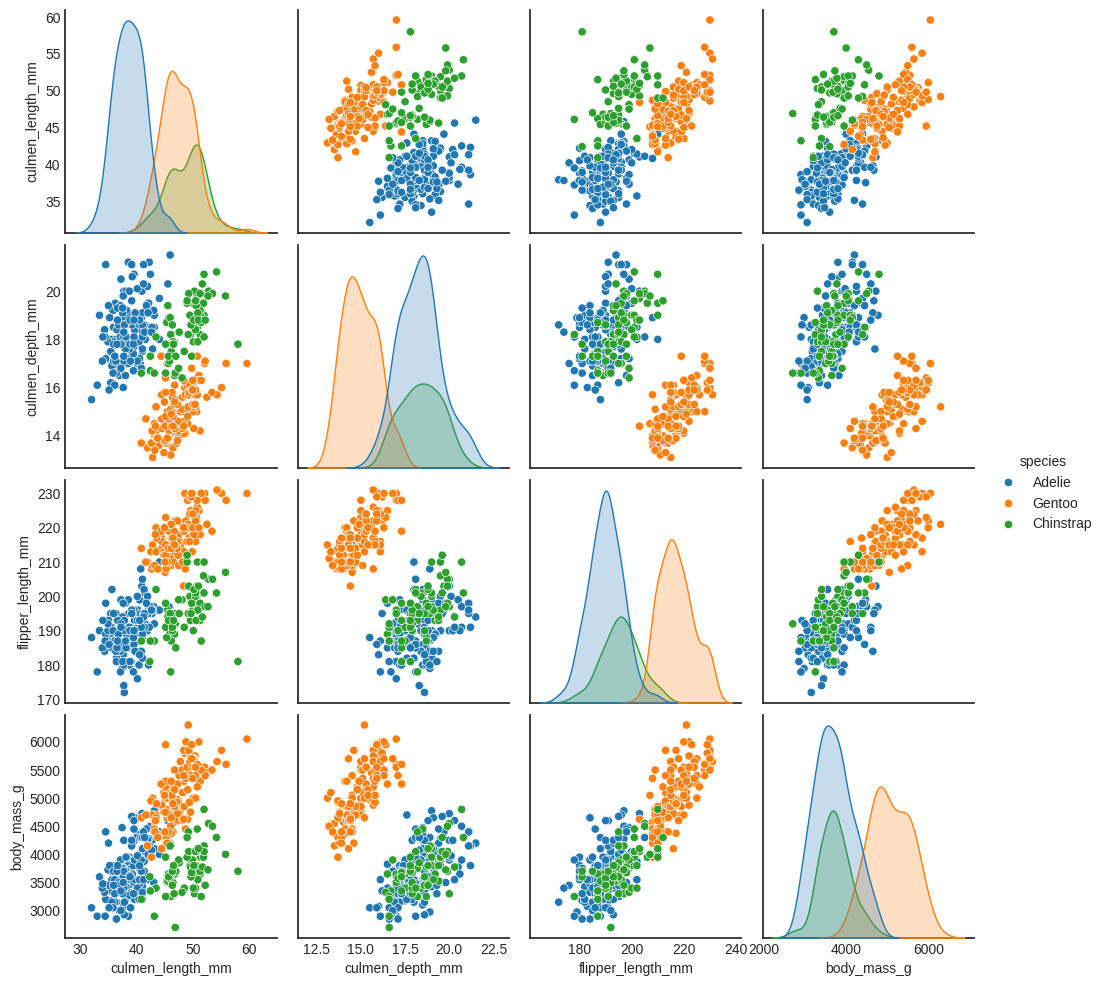

In [24]:
sns.pairplot(pdf, hue = 'species')
plt.show()

This concludes exploratory data analysis.

# Module 02: Feature Engineering

In [25]:
import numpy as np #linear algebra
import pandas as pd #data processing
import pandas_gbq #write to BQ

import matplotlib.pyplot as plt #simple data visualization
import seaborn as sns #some advanced data visualizations
import warnings

%matplotlib inline
plt.style.use('seaborn-white') #defining desired style of viz
warnings.filterwarnings('ignore') # to get rid of warnings

from sklearn.preprocessing import LabelEncoder #label encoding
from google.cloud import bigquery

In [26]:
# Variables
project_id_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = project_id_output[0]
print("Project ID: ", PROJECT_ID)

project_nbr_output = !gcloud projects describe $PROJECT_ID --format='value(projectNumber)'
PROJECT_NBR = project_nbr_output[0]
print("Project Number: ", PROJECT_NBR)

Project ID:  ray-of-sunshine
Project Number:  567162267085


## M02-1. Read base data from BigQuery

In [27]:
from google.cloud import bigquery

client = bigquery.Client()
sql = """
    SELECT *
    FROM `ray_lab_ds.penguins_curated`
"""

base_df = client.query(sql).to_dataframe()

## M02-2. Missing values imputation

In [28]:
# Check if any of the columns have missing values
base_df.isnull().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

In [29]:
# Lets make a copy of the base dataset and apply in-place missing values imputation
missing_values_imputed_df = base_df.copy()

In [30]:
# Imputation strategy: Apply mean for the numerical columns
missing_values_imputed_df['culmen_length_mm'].fillna(np.mean(base_df['culmen_length_mm']), inplace = True)
missing_values_imputed_df['culmen_depth_mm'].fillna(np.mean(base_df['culmen_depth_mm']), inplace = True)
missing_values_imputed_df['flipper_length_mm'].fillna(np.mean(base_df['flipper_length_mm']), inplace = True)
missing_values_imputed_df['body_mass_g'].fillna(np.mean(base_df['body_mass_g']), inplace = True)

# Imputation strategy: Apply mode for the categorical columns
missing_values_imputed_df['sex'].fillna(base_df['sex'].mode()[0], inplace = True)

In [31]:
missing_values_imputed_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,43.92193,17.15117,200.915205,4201.754386,MALE
1,Adelie,Dream,32.10000,15.50000,188.000000,3050.000000,FEMALE
2,Adelie,Biscoe,37.70000,16.00000,183.000000,3075.000000,FEMALE
3,Adelie,Dream,36.40000,17.00000,195.000000,3325.000000,FEMALE
4,Adelie,Biscoe,37.60000,17.00000,185.000000,3600.000000,FEMALE


In [32]:
missing_values_imputed_df.isnull().sum()

species              0
island               0
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

## M02-3. Feature transformation

### M02-3.1. Check for skew

In [33]:
print('Skewness in numeric variables')
print('-' * 60)

for i in missing_values_imputed_df.select_dtypes(['int64', 'float64']).columns.tolist():
    print(i, ' : ',missing_values_imputed_df[i].skew())

Skewness in numeric variables
------------------------------------------------------------
culmen_length_mm  :  0.053271788831638016
culmen_depth_mm  :  -0.14387980683507479
flipper_length_mm  :  0.34668222408256016
body_mass_g  :  0.4716904472211899


Skewness score:

Skewness values within the range of -1 and -0.5 (negative skewed) or 0.5 and 1(positive skewed) indicate slightly skewed data distributions. Data with skewness values less than -1 (negative skewed) or greater than 1 (positive skewed) are considered highly skewed.


Interpreting the results:
Skew is not a great concern

### M02-3.2. Normalization

Data normalization is a technique used to transform the values of a dataset into a common scale. This is important because many machine learning algorithms are sensitive to the scale of the input features and can produce better results when the data is normalized.

#### M02-3.2.1. Numerical values - scaling

In [34]:
# Lets use sklearn's MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [35]:
missing_values_imputed_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,43.92193,17.15117,200.915205,4201.754386,MALE
1,Adelie,Dream,32.10000,15.50000,188.000000,3050.000000,FEMALE
2,Adelie,Biscoe,37.70000,16.00000,183.000000,3075.000000,FEMALE
3,Adelie,Dream,36.40000,17.00000,195.000000,3325.000000,FEMALE
4,Adelie,Biscoe,37.60000,17.00000,185.000000,3600.000000,FEMALE


In [36]:
missing_values_imputed_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,344.000000,344.000000,344.000000,344.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.443643,1.969027,14.020657,799.613058
min,32.100000,13.100000,172.000000,2700.000000
25%,39.275000,15.600000,190.000000,3550.000000
50%,44.250000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [37]:
imputed_scaled_df = missing_values_imputed_df.copy()

In [38]:
imputed_scaled_df['culmen_length_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['culmen_length_mm'].values.reshape(-1, 1))
imputed_scaled_df['culmen_depth_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['culmen_depth_mm'].values.reshape(-1, 1))
imputed_scaled_df['flipper_length_mm'] = min_max_scaler.fit_transform(missing_values_imputed_df['flipper_length_mm'].values.reshape(-1, 1))
imputed_scaled_df['body_mass_g'] = min_max_scaler.fit_transform(missing_values_imputed_df['body_mass_g'].values.reshape(-1, 1))

In [39]:
imputed_scaled_df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,0.429888,0.482282,0.490088,0.417154,MALE
1,Adelie,Dream,0.000000,0.285714,0.271186,0.097222,FEMALE
2,Adelie,Biscoe,0.203636,0.345238,0.186441,0.104167,FEMALE
3,Adelie,Dream,0.156364,0.464286,0.389831,0.173611,FEMALE
4,Adelie,Biscoe,0.200000,0.464286,0.220339,0.250000,FEMALE


In [40]:
imputed_scaled_df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,344.000000,344.000000,344.000000,344.000000
mean,0.429888,0.482282,0.490088,0.417154
std,0.197951,0.234408,0.237638,0.222115
min,0.000000,0.000000,0.000000,0.000000
25%,0.260909,0.297619,0.305085,0.236111
50%,0.441818,0.500000,0.423729,0.375000
75%,0.596364,0.666667,0.694915,0.569444
max,1.000000,1.000000,1.000000,1.000000


#### M02-3.2.2. Categorical variables - one hot encoding Penguin gender

In [41]:
imputed_scaled_gender_encoded_df=pd.get_dummies(imputed_scaled_df,columns = ['sex'], drop_first=True).drop(['sex_FEMALE'], axis=1)
imputed_scaled_gender_encoded_df.rename(columns={"sex_MALE":"male"}, inplace=True)
imputed_scaled_gender_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,Adelie,Torgersen,0.429888,0.482282,0.490088,0.417154,1
1,Adelie,Dream,0.000000,0.285714,0.271186,0.097222,0
2,Adelie,Biscoe,0.203636,0.345238,0.186441,0.104167,0


#### M02-3.2.3. Categorical variables - one hot encoding island

In [42]:
imputed_scaled_encoded_df=imputed_scaled_gender_encoded_df.copy()
imputed_scaled_encoded_df['island'].unique()

array(['Torgersen', 'Dream', 'Biscoe'], dtype=object)

In [43]:
imputed_scaled_encoded_df['island'].replace({'Dream' : 0,
                                'Biscoe' : 1,
                                'Torgersen': 2}, inplace = True)
imputed_scaled_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,Adelie,2,0.429888,0.482282,0.490088,0.417154,1
1,Adelie,0,0.000000,0.285714,0.271186,0.097222,0
2,Adelie,1,0.203636,0.345238,0.186441,0.104167,0


#### M02-3.2.4. Label encoding

In [44]:
le = LabelEncoder()
imputed_scaled_encoded_df['species']= le.fit_transform(imputed_scaled_encoded_df['species'])
imputed_scaled_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,0,2,0.429888,0.482282,0.490088,0.417154,1
1,0,0,0.000000,0.285714,0.271186,0.097222,0
2,0,1,0.203636,0.345238,0.186441,0.104167,0


In [45]:
imputed_scaled_encoded_df.describe()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
count,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000,344.000000
mean,0.918605,0.790698,0.429888,0.482282,0.490088,0.417154,0.517442
std,0.893320,0.684970,0.197951,0.234408,0.237638,0.222115,0.500424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.260909,0.297619,0.305085,0.236111,0.000000
50%,1.000000,1.000000,0.441818,0.500000,0.423729,0.375000,1.000000
75%,2.000000,1.000000,0.596364,0.666667,0.694915,0.569444,1.000000
max,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [46]:
imputed_scaled_encoded_df.species.unique()

array([0, 2, 1])

In [47]:
imputed_scaled_encoded_df.island.unique()

array([2, 0, 1])

In [48]:
imputed_scaled_encoded_df.male.unique()

array([1, 0], dtype=uint8)

## M02-4. Correlation

<Axes: >

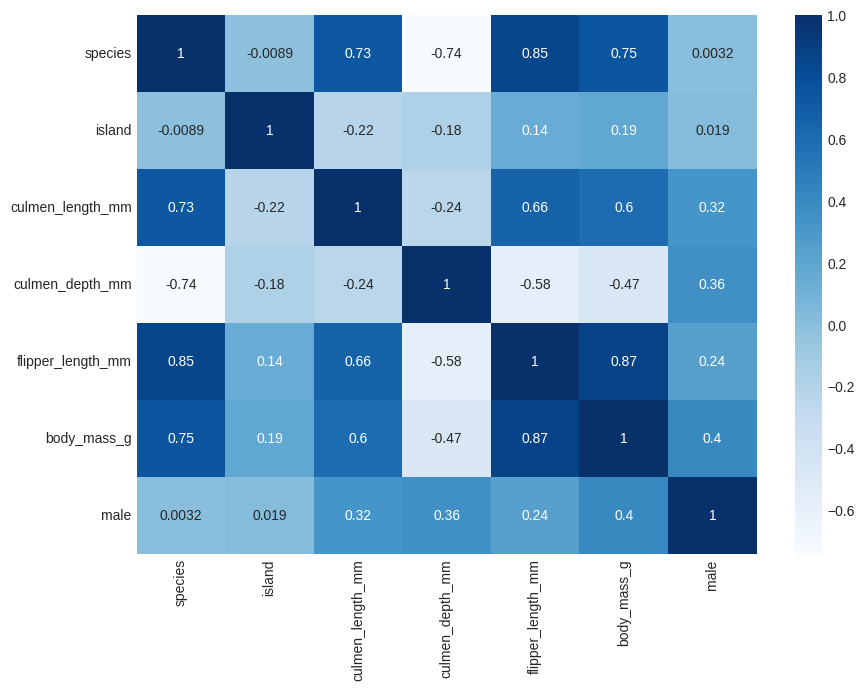

In [49]:
sns.heatmap(imputed_scaled_encoded_df.corr(), annot = True, cmap = 'Blues')

## M02-5. Persist features to BigQuery

In [50]:
imputed_scaled_encoded_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,0,2,0.429888,0.482282,0.490088,0.417154,1
1,0,0,0.000000,0.285714,0.271186,0.097222,0
2,0,1,0.203636,0.345238,0.186441,0.104167,0


In [51]:
bq_client = bigquery.Client()

In [52]:
table_id="ray_lab_ds.penguins_feature_engineered"

job_config = bigquery.LoadJobConfig(
    schema=[
        # Specify the type of columns whose type cannot be auto-detected. For
        # example the "title" column uses pandas dtype "object", so its
        # data type is ambiguous.
        bigquery.SchemaField("species", bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField("island", bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField("culmen_length_mm", bigquery.enums.SqlTypeNames.FLOAT),
        bigquery.SchemaField("culmen_depth_mm", bigquery.enums.SqlTypeNames.FLOAT),
        bigquery.SchemaField("flipper_length_mm", bigquery.enums.SqlTypeNames.FLOAT),
        bigquery.SchemaField("body_mass_g", bigquery.enums.SqlTypeNames.FLOAT),
        bigquery.SchemaField("male", bigquery.enums.SqlTypeNames.INTEGER),

    ],
    write_disposition="WRITE_TRUNCATE",
)

job = client.load_table_from_dataframe(
    imputed_scaled_encoded_df, table_id, job_config=job_config
)  # Make an API request.
job.result()  # Wait for the job to complete.

table = client.get_table(table_id)  # Make an API request.
print(
    "Loaded {} rows and {} columns to {}".format(
        table.num_rows, len(table.schema), table_id
    )
)

Loaded 344 rows and 7 columns to ray_lab_ds.penguins_feature_engineered


This concludes the feature engineering module.

# Module 03: Model Training

In [53]:
import numpy as np #linear algebra
import pandas as pd #data processing
import pandas_gbq #write to BQ

import matplotlib.pyplot as plt #simple data visualization
import seaborn as sns #some advanced data visualizations
import warnings
import pickle

%matplotlib inline
plt.style.use('seaborn-white') #defining desired style of viz
warnings.filterwarnings('ignore') # to get rid of warnings

from google.cloud import bigquery, storage, aiplatform as vertex_ai
from sklearn.preprocessing import LabelEncoder #label encoding

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import Pipeline

In [54]:
# Variables
project_id_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT_ID = project_id_output[0]
print("Project ID: ", PROJECT_ID)

project_nbr_output = !gcloud projects describe $PROJECT_ID --format='value(projectNumber)'
PROJECT_NBR = project_nbr_output[0]
print("Project Number: ", PROJECT_NBR)

Project ID:  ray-of-sunshine
Project Number:  567162267085


## M03-1. Read training dataset in BigQuery

In [55]:
from google.cloud import bigquery

client = bigquery.Client()
sql = """
    SELECT *
    FROM `ray_lab_ds.penguins_feature_engineered`
"""

feature_engineered_df = client.query(sql).to_dataframe()
feature_engineered_df.head(3)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,0,0,0.000000,0.285714,0.271186,0.097222,0
1,0,0,0.156364,0.464286,0.389831,0.173611,0
2,0,0,0.130909,0.583333,0.508475,0.236111,0


## M03-2. Features

In [56]:
X = feature_engineered_df.drop(columns = ['species'])
X.head(3)

,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,male
0,0,0.000000,0.285714,0.271186,0.097222,0
1,0,0.156364,0.464286,0.389831,0.173611,0
2,0,0.130909,0.583333,0.508475,0.236111,0


## M03-3. Label

In [57]:
Y = feature_engineered_df['species']
Y.head(3)

0    0
1    0
2    0
Name: species, dtype: Int64

## M03-4. Split the data for training & test

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 123)

## M03-5. Train multiple models simultaneously and review metrics

In [59]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('kNN', KNeighborsClassifier()))

In [60]:
for name, model in models:
    kfold = KFold(n_splits = 5, random_state = 42, shuffle=True)
    cv_res = cross_val_score(model, X_train, Y_train, scoring = 'accuracy', cv = kfold)
    print(name, ' : ', cv_res.mean())

LR  :  0.9883861236802414
DT  :  0.96131221719457
RF  :  0.9767722473604827
kNN  :  0.9961538461538462


Lets settle on Random Forest for the rest of the lab.

## M03-6. Train a Random Forest Classification model

In [61]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, Y_train)

RandomForestClassifier()

## M03-7. Evaluate the Random Forest Classification model

### M03-7.1. Run predictions against the test data

In [62]:
random_forest_predictions = random_forest_model.predict(X_test)

### M03-7.2. Metrics

#### M03-7.2.1. At a glance

In [63]:
print('Accuracy : ', accuracy_score(Y_test, random_forest_predictions))
print('F1 Score : ', f1_score(Y_test, random_forest_predictions, average = 'weighted'))
print('Precision : ', precision_score(Y_test, random_forest_predictions , average = 'weighted'))
print('Recall : ', recall_score(Y_test, random_forest_predictions, average = 'weighted'))

Accuracy :  0.9883720930232558
F1 Score :  0.9883264933880528
Precision :  0.9886425094645754
Recall :  0.9883720930232558


#### M03-7.2.2. As a table

In [64]:
print(classification_report(Y_test, random_forest_predictions))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        42
         1.0       1.00      1.00      1.00        18
         2.0       1.00      0.96      0.98        26

    accuracy                           0.99        86
   macro avg       0.99      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86



#### M03-7.2.3. Confusion Matrix

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(Y_test, random_forest_predictions))

[[42  0  0]
 [ 0 18  0]
 [ 1  0 25]]


In [66]:
cm=confusion_matrix(Y_test, random_forest_predictions)

#### M03-7.2.4. As a heat map

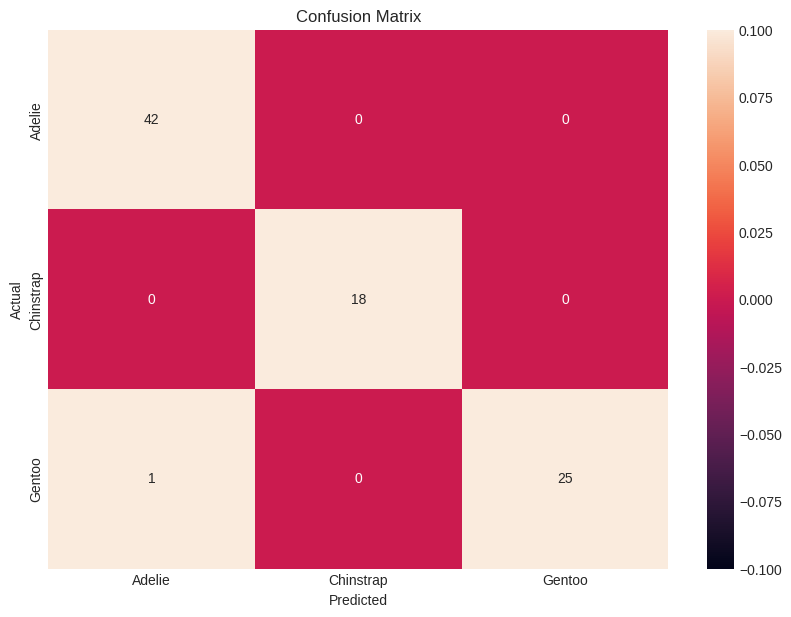

In [67]:
sns.heatmap(cm, annot=True, vmin=0, vmax=0, xticklabels=['Adelie', 'Chinstrap', 'Gentoo'], yticklabels=['Adelie', 'Chinstrap', 'Gentoo'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

It looks too good to be true.

## M03-8. Register the model into Vertex AI Model Registry

Persist locally

In [68]:
import pickle

# Model file name
model_filename = "model.pkl"

# Save model to file locally
pickle.dump(random_forest_model, open(model_filename, "wb"))

Then to Google Cloud Storage

In [69]:
bucket_id=f"ray_lab_model_bucket_{PROJECT_NBR}"
bucket_path = "penguin_species_predictor_pop"
model_bucket_fq_gcs_uri="{}/{}".format(bucket_id,bucket_path)
print(f"Model persistence location: {model_bucket_fq_gcs_uri}")

Model persistence location: ray_lab_model_bucket_567162267085/penguin_species_predictor_pop


In [70]:
# Upload the model to GCS
bucket = storage.Client().bucket(bucket_id)
blob = bucket.blob('{}/{}'.format(
    bucket_path,
    model_filename))
blob.upload_from_filename(model_filename)

Then to Vertex AI Model Registry

In [71]:
DEPLOY_IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-3:latest"
MODEL_NAME = "penguin_species_predictor_pop"
DEPLOY_COMPUTE = "n1-standard-4"

In [74]:
registered_model_reference = vertex_ai.Model.upload(
    display_name=MODEL_NAME,
    serving_container_image_uri=DEPLOY_IMAGE_URI,
    artifact_uri="gs://{}".format(model_bucket_fq_gcs_uri)
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/567162267085/locations/us-central1/models/1933941997211484160/operations/6212715720317337600
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/567162267085/locations/us-central1/models/1933941997211484160@1
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/567162267085/locations/us-central1/models/1933941997211484160@1')


## M03-9. Deploy to Vertex AI predictions endpoint

### M03-9.1. Create an endpoint resource

In [104]:
endpoint = vertex_ai.Endpoint.create(
    display_name="penguins_species_predictor_pop_endpoint_resource",
    project=PROJECT_ID,
    location=REGION
)

print(endpoint)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/567162267085/locations/us-central1/endpoints/686616424243789824/operations/6580603514878164992
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/567162267085/locations/us-central1/endpoints/686616424243789824
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/567162267085/locations/us-central1/endpoints/686616424243789824')


resource name: projects/567162267085/locations/us-central1/endpoints/686616424243789824


In [105]:
endpoint

resource name: projects/567162267085/locations/us-central1/endpoints/686616424243789824

### M03-9.2. Deploy model resource to the endpoint resource

In [ ]:
DEPLOY_COMPUTE = "n1-standard-8"

response = endpoint.deploy(
    model=registered_model_reference,
    deployed_model_display_name="penguins_species_predictor_pop_endpoint_model",
    machine_type=DEPLOY_COMPUTE,
)

print(endpoint)

INFO:google.cloud.aiplatform.models:Deploying Model projects/567162267085/locations/us-central1/models/1933941997211484160 to Endpoint : projects/567162267085/locations/us-central1/endpoints/686616424243789824
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/567162267085/locations/us-central1/endpoints/686616424243789824/operations/320600032833175552


## M03-10. Run prediction against Vertex AI predictions endpoint

Lets construct 3 records to test...

In [ ]:
feature_engineered_df.head(3)

In [ ]:
endpoint.predict(instances=[[0,0.000000,0.285714,0.271186,0.097222,0]])